In [4]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [6]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, _ = l.selu_forward(X=y)
#         if train:
#             y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#             caches.append((fc_cache, do_cache)) # caches[0]
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, ys_L, do_caches = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, _ = l.selu_forward(X=y)
#             if train:
#                 y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#                 do_caches.append(do_cache)
            fc_caches.append(fc_cache)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
#         if train:
#             caches.append((fc_caches, do_caches)) # caches[1]
        if train:
            caches.append(fc_caches) # caches[1]
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
            caches.append((fc_cache, do_cache)) # caches[2]
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache, do_cache = caches[2]
        dy = l.dropout_backward(cache=do_cache, dout=dy)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
#         fc_caches, do_caches = caches[1]
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.dropout_backward(cache=do_caches[layer], dout=dy)
#             dy = l.selu_backward(cache=nl_caches[layer], dout=dy)
#             dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
            dy *= self.ys[1][layer] - self.ys_prev[1][layer] # function derivative or dfunc
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
#         fc_cache, do_cache = caches[0]
        fc_cache = caches[0]
#         dy = l.dropout_backward(cache=do_cache, dout=dy)
#         dy = l.selu_backward(cache=nl_cache, dout=dy)
#         dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
        dy *= self.ys[0] - self.ys_prev[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        # dy = dX.copy()
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            self.ys, caches = self.train_forward(X_mini, train=True)
#             print(self.ys[2].shape)
            loss, dy = self.loss_function(self.ys[2], y_mini)
            _, grads = self.train_backward(dy, caches) # self.ys_prev is used here for dfunc/ diff
            self.ys_prev = self.ys # for next iteration or epoch
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [7]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.3149 valid loss: 2.3169, valid accuracy: 0.1036
Iter-200 train loss: 2.3083 valid loss: 2.3165, valid accuracy: 0.1038
Iter-300 train loss: 2.3061 valid loss: 2.3162, valid accuracy: 0.1040
Iter-400 train loss: 2.3044 valid loss: 2.3159, valid accuracy: 0.1044
Iter-500 train loss: 2.3039 valid loss: 2.3155, valid accuracy: 0.1046
Iter-600 train loss: 2.2960 valid loss: 2.3151, valid accuracy: 0.1046
Iter-700 train loss: 2.3109 valid loss: 2.3147, valid accuracy: 0.1046
Iter-800 train loss: 2.3041 valid loss: 2.3143, valid accuracy: 0.1046
Iter-900 train loss: 2.3007 valid loss: 2.3140, valid accuracy: 0.1046
Iter-1000 train loss: 2.3120 valid loss: 2.3137, valid accuracy: 0.1048
Iter-1100 train loss: 2.2916 valid loss: 2.3133, valid accuracy: 0.1048
Iter-1200 train loss: 2.3091 valid loss: 2.3129, valid accuracy: 0.1050
Iter-1300 train loss: 2.2946 valid loss: 2.3126, valid accuracy: 0.1056
Iter-1400 train loss: 2.3088 valid loss: 2.3122, valid accuracy: 0.1056
I

Iter-11500 train loss: 2.3015 valid loss: 2.2786, valid accuracy: 0.1404
Iter-11600 train loss: 2.2951 valid loss: 2.2783, valid accuracy: 0.1406
Iter-11700 train loss: 2.3049 valid loss: 2.2780, valid accuracy: 0.1416
Iter-11800 train loss: 2.2989 valid loss: 2.2777, valid accuracy: 0.1426
Iter-11900 train loss: 2.3081 valid loss: 2.2774, valid accuracy: 0.1428
Iter-12000 train loss: 2.3098 valid loss: 2.2770, valid accuracy: 0.1438
Iter-12100 train loss: 2.3014 valid loss: 2.2767, valid accuracy: 0.1444
Iter-12200 train loss: 2.3171 valid loss: 2.2764, valid accuracy: 0.1448
Iter-12300 train loss: 2.3075 valid loss: 2.2760, valid accuracy: 0.1454
Iter-12400 train loss: 2.3021 valid loss: 2.2756, valid accuracy: 0.1460
Iter-12500 train loss: 2.3024 valid loss: 2.2753, valid accuracy: 0.1460
Iter-12600 train loss: 2.3110 valid loss: 2.2750, valid accuracy: 0.1462
Iter-12700 train loss: 2.2906 valid loss: 2.2747, valid accuracy: 0.1462
Iter-12800 train loss: 2.2969 valid loss: 2.2743, v

Iter-22800 train loss: 2.3076 valid loss: 2.2431, valid accuracy: 0.1814
Iter-22900 train loss: 2.3056 valid loss: 2.2428, valid accuracy: 0.1818
Iter-23000 train loss: 2.3059 valid loss: 2.2425, valid accuracy: 0.1828
Iter-23100 train loss: 2.3009 valid loss: 2.2422, valid accuracy: 0.1828
Iter-23200 train loss: 2.2896 valid loss: 2.2419, valid accuracy: 0.1830
Iter-23300 train loss: 2.3064 valid loss: 2.2415, valid accuracy: 0.1828
Iter-23400 train loss: 2.3049 valid loss: 2.2413, valid accuracy: 0.1832
Iter-23500 train loss: 2.2966 valid loss: 2.2409, valid accuracy: 0.1830
Iter-23600 train loss: 2.3010 valid loss: 2.2406, valid accuracy: 0.1832
Iter-23700 train loss: 2.2932 valid loss: 2.2403, valid accuracy: 0.1836
Iter-23800 train loss: 2.3096 valid loss: 2.2400, valid accuracy: 0.1840
Iter-23900 train loss: 2.3011 valid loss: 2.2397, valid accuracy: 0.1844
Iter-24000 train loss: 2.2952 valid loss: 2.2394, valid accuracy: 0.1846
Iter-24100 train loss: 2.3040 valid loss: 2.2391, v

Iter-34100 train loss: 2.3021 valid loss: 2.2098, valid accuracy: 0.2194
Iter-34200 train loss: 2.3087 valid loss: 2.2096, valid accuracy: 0.2200
Iter-34300 train loss: 2.2928 valid loss: 2.2093, valid accuracy: 0.2204
Iter-34400 train loss: 2.2982 valid loss: 2.2089, valid accuracy: 0.2218
Iter-34500 train loss: 2.2946 valid loss: 2.2086, valid accuracy: 0.2224
Iter-34600 train loss: 2.3005 valid loss: 2.2083, valid accuracy: 0.2228
Iter-34700 train loss: 2.2936 valid loss: 2.2080, valid accuracy: 0.2230
Iter-34800 train loss: 2.3029 valid loss: 2.2077, valid accuracy: 0.2240
Iter-34900 train loss: 2.2982 valid loss: 2.2074, valid accuracy: 0.2242
Iter-35000 train loss: 2.3041 valid loss: 2.2072, valid accuracy: 0.2242
Iter-35100 train loss: 2.3096 valid loss: 2.2069, valid accuracy: 0.2246
Iter-35200 train loss: 2.2977 valid loss: 2.2066, valid accuracy: 0.2248
Iter-35300 train loss: 2.3028 valid loss: 2.2064, valid accuracy: 0.2252
Iter-35400 train loss: 2.3023 valid loss: 2.2061, v

Iter-45400 train loss: 2.2990 valid loss: 2.1779, valid accuracy: 0.2576
Iter-45500 train loss: 2.3062 valid loss: 2.1776, valid accuracy: 0.2574
Iter-45600 train loss: 2.2980 valid loss: 2.1773, valid accuracy: 0.2580
Iter-45700 train loss: 2.2918 valid loss: 2.1770, valid accuracy: 0.2588
Iter-45800 train loss: 2.2843 valid loss: 2.1767, valid accuracy: 0.2592
Iter-45900 train loss: 2.2924 valid loss: 2.1765, valid accuracy: 0.2594
Iter-46000 train loss: 2.3106 valid loss: 2.1762, valid accuracy: 0.2594
Iter-46100 train loss: 2.3041 valid loss: 2.1759, valid accuracy: 0.2598
Iter-46200 train loss: 2.3030 valid loss: 2.1756, valid accuracy: 0.2598
Iter-46300 train loss: 2.2923 valid loss: 2.1754, valid accuracy: 0.2600
Iter-46400 train loss: 2.3065 valid loss: 2.1751, valid accuracy: 0.2604
Iter-46500 train loss: 2.2892 valid loss: 2.1749, valid accuracy: 0.2606
Iter-46600 train loss: 2.3184 valid loss: 2.1747, valid accuracy: 0.2610
Iter-46700 train loss: 2.3012 valid loss: 2.1744, v

Iter-56700 train loss: 2.2998 valid loss: 2.1478, valid accuracy: 0.2850
Iter-56800 train loss: 2.2894 valid loss: 2.1476, valid accuracy: 0.2850
Iter-56900 train loss: 2.2776 valid loss: 2.1473, valid accuracy: 0.2852
Iter-57000 train loss: 2.2992 valid loss: 2.1470, valid accuracy: 0.2852
Iter-57100 train loss: 2.3068 valid loss: 2.1468, valid accuracy: 0.2856
Iter-57200 train loss: 2.2918 valid loss: 2.1465, valid accuracy: 0.2858
Iter-57300 train loss: 2.2923 valid loss: 2.1462, valid accuracy: 0.2864
Iter-57400 train loss: 2.2722 valid loss: 2.1460, valid accuracy: 0.2866
Iter-57500 train loss: 2.2935 valid loss: 2.1457, valid accuracy: 0.2870
Iter-57600 train loss: 2.2854 valid loss: 2.1455, valid accuracy: 0.2870
Iter-57700 train loss: 2.2836 valid loss: 2.1453, valid accuracy: 0.2870
Iter-57800 train loss: 2.2921 valid loss: 2.1450, valid accuracy: 0.2878
Iter-57900 train loss: 2.2977 valid loss: 2.1447, valid accuracy: 0.2884
Iter-58000 train loss: 2.3022 valid loss: 2.1445, v

Iter-68000 train loss: 2.2961 valid loss: 2.1195, valid accuracy: 0.3150
Iter-68100 train loss: 2.2999 valid loss: 2.1193, valid accuracy: 0.3152
Iter-68200 train loss: 2.3010 valid loss: 2.1190, valid accuracy: 0.3162
Iter-68300 train loss: 2.2866 valid loss: 2.1187, valid accuracy: 0.3166
Iter-68400 train loss: 2.2869 valid loss: 2.1185, valid accuracy: 0.3170
Iter-68500 train loss: 2.2883 valid loss: 2.1183, valid accuracy: 0.3172
Iter-68600 train loss: 2.2787 valid loss: 2.1181, valid accuracy: 0.3182
Iter-68700 train loss: 2.2988 valid loss: 2.1179, valid accuracy: 0.3184
Iter-68800 train loss: 2.3060 valid loss: 2.1177, valid accuracy: 0.3182
Iter-68900 train loss: 2.2942 valid loss: 2.1175, valid accuracy: 0.3182
Iter-69000 train loss: 2.3036 valid loss: 2.1172, valid accuracy: 0.3184
Iter-69100 train loss: 2.2986 valid loss: 2.1169, valid accuracy: 0.3184
Iter-69200 train loss: 2.2740 valid loss: 2.1167, valid accuracy: 0.3190
Iter-69300 train loss: 2.2915 valid loss: 2.1164, v

Iter-79300 train loss: 2.2993 valid loss: 2.0930, valid accuracy: 0.3396
Iter-79400 train loss: 2.2820 valid loss: 2.0928, valid accuracy: 0.3394
Iter-79500 train loss: 2.2896 valid loss: 2.0926, valid accuracy: 0.3396
Iter-79600 train loss: 2.3006 valid loss: 2.0924, valid accuracy: 0.3398
Iter-79700 train loss: 2.3031 valid loss: 2.0921, valid accuracy: 0.3402
Iter-79800 train loss: 2.2876 valid loss: 2.0919, valid accuracy: 0.3402
Iter-79900 train loss: 2.2843 valid loss: 2.0917, valid accuracy: 0.3400
Iter-80000 train loss: 2.3016 valid loss: 2.0914, valid accuracy: 0.3400
Iter-80100 train loss: 2.3071 valid loss: 2.0912, valid accuracy: 0.3400
Iter-80200 train loss: 2.2896 valid loss: 2.0910, valid accuracy: 0.3402
Iter-80300 train loss: 2.2993 valid loss: 2.0907, valid accuracy: 0.3404
Iter-80400 train loss: 2.2960 valid loss: 2.0905, valid accuracy: 0.3406
Iter-80500 train loss: 2.3155 valid loss: 2.0903, valid accuracy: 0.3406
Iter-80600 train loss: 2.2840 valid loss: 2.0901, v

Iter-90600 train loss: 2.2708 valid loss: 2.0678, valid accuracy: 0.3596
Iter-90700 train loss: 2.2940 valid loss: 2.0676, valid accuracy: 0.3592
Iter-90800 train loss: 2.2788 valid loss: 2.0674, valid accuracy: 0.3596
Iter-90900 train loss: 2.2552 valid loss: 2.0672, valid accuracy: 0.3596
Iter-91000 train loss: 2.2689 valid loss: 2.0670, valid accuracy: 0.3600
Iter-91100 train loss: 2.2776 valid loss: 2.0668, valid accuracy: 0.3600
Iter-91200 train loss: 2.2521 valid loss: 2.0666, valid accuracy: 0.3602
Iter-91300 train loss: 2.2667 valid loss: 2.0664, valid accuracy: 0.3602
Iter-91400 train loss: 2.3099 valid loss: 2.0662, valid accuracy: 0.3602
Iter-91500 train loss: 2.2916 valid loss: 2.0660, valid accuracy: 0.3606
Iter-91600 train loss: 2.2918 valid loss: 2.0657, valid accuracy: 0.3608
Iter-91700 train loss: 2.2724 valid loss: 2.0655, valid accuracy: 0.3612
Iter-91800 train loss: 2.2971 valid loss: 2.0653, valid accuracy: 0.3618
Iter-91900 train loss: 2.2891 valid loss: 2.0651, v

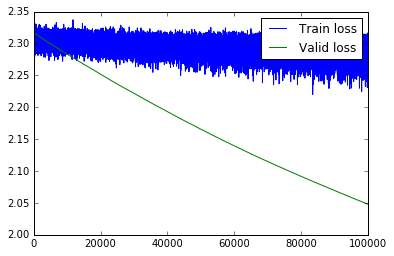

In [8]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

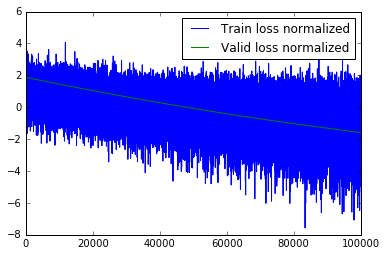

In [14]:
loss_train = np.array(nn.losses['train'])
loss_train_norm = (loss_train - loss_train.mean(axis=0))/ loss_train.std(axis=0)

loss_valid = np.array(nn.losses['valid'])
loss_valid_norm = (loss_valid - loss_valid.mean(axis=0))/ loss_valid.std(axis=0)

plt.plot(loss_train_norm, label='Train loss normalized')
plt.plot(loss_valid_norm, label='Valid loss normalized')
plt.legend()
plt.show()

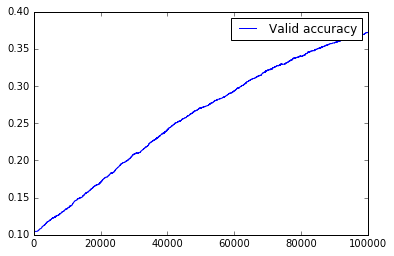

In [9]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()